# Lab 3: MDP and QMDP
This lab aims to show you how to formulate a problem as an MDP (POMDP) and solve it using value iteration, policy iteration, and approximated solution for POMDP such as QMDP.

## 1. MDP
### Task 1.1: MDP formulation
We provide you with a class `MDP()` to help you easily formulate your MDP problem. Refer to your lab handout for instructions on how to use the class.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from mdp import MDP

Test out the class with the simple two-state problem in the handout

In [ ]:
class TwoStateMDP(MDP):
    def __init__(self):
        self.states = [["s1", "s2"]]
        self.actions = ["a0", "a1"]
        self.gam = 0.9
    
        # call the parent class
        # notice that the state is a list of state variables
        super().__init__(
            states=self.states, actions=self.actions)
        self.populate_data()
    
    def populate_data(self):
        # add all routes from s1
        self.add_route(["s1"],"a0",["s1"])
        self.add_route(["s1"],"a1",["s2"])
        # add all routes from s2
        self.add_route(["s2"],"a0",["s2"])
        self.add_route(["s2"],"a1",["s2"])
        
        # let's populate the reward, assuming r>0 is 0.5
        for a in self.a:
            self.add_reward(["s1"], a, 0.5)
            self.add_reward(["s2"], a, 1.5)

In [3]:
twoStateMDP = TwoStateMDP()
assert twoStateMDP.get_index(["s1"]) == 0, "Something is wrong"
assert twoStateMDP.get_state(0) == [0], "Something is wrong"
assert twoStateMDP.get_real_state_value(0) == ['s1'], "Something is wrong"
print("Everything is correct!")

Everything is correct!


In [4]:
P = twoStateMDP.P
print(P)
for i in range(P.shape[0]):
    for j in range(P.shape[0]):
        for k in range(P.shape[0]):
            print(f'P[{i}, {j}, {k}]: {P[i, j, k]}')

print(P.transpose((2, 1, 0)))

[[[1. 0.]
  [0. 0.]]

 [[0. 1.]
  [1. 1.]]]
P[0, 0, 0]: 1.0
P[0, 0, 1]: 0.0
P[0, 1, 0]: 0.0
P[0, 1, 1]: 0.0
P[1, 0, 0]: 0.0
P[1, 0, 1]: 1.0
P[1, 1, 0]: 1.0
P[1, 1, 1]: 1.0
[[[1. 0.]
  [0. 1.]]

 [[0. 1.]
  [0. 1.]]]


Now let's use the `MDP()` class to formulate our T-intersection problem.

**Task 1.1**: In `populate_data()`, all the probability value for each `self.add_route()` command is missing (denotes `MISSING_VALUE`). Compute the state transition matrix of the T-intersection MDP and fill in the missing `p` values.

In [5]:
### TASK 1.1: Fill in MISSING_VALUE with correct p values
class TIntersection(MDP):
    def __init__(self, reward={"forward": -1.0, "stop": -5, "collision": -10, "goal": 5.0}):
        self.states = [
            ["ego_{}".format(x) for x in list(range(1, 6))],
            ["car_{}".format(x) for x in list(range(1, 6))]
        ]
        self.actions = ["forward", "stop"]
        self.gam = 0.9
        super().__init__(
            states=self.states, actions=self.actions, method="add")
        self.reward = reward
        self.populate_data()
    
    def populate_data(self):
        for i in range(1, 6):
            for j in range(1, 6):
                # add route for forward action
                # (i, j) --> (i+1, j)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+1, 5)), "car_{}".format(j)], 0.64) #0.8*0.8
                # (i, j) --> (i+1, j+1)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+1, 5)), "car_{}".format(min(j+1, 5))], 0.128) #0.8*0.2*0.8
                # (i, j) --> (i+1, j+2)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+1, 5)), "car_{}".format(min(j+2, 5))], 0.032) #0.8*0.2*0.2
                # (i, j) --> (i+2, j)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+2, 5)), "car_{}".format(j)], 0.16) #0.2*0.8
                # (i, j) --> (i+2, j+1)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+2, 5)), "car_{}".format(min(j+1, 5))], 0.032) #0.2*0.2*0.8
                # (i, j) --> (i+2, j+2)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+2, 5)), "car_{}".format(min(j+2, 5))], 0.008) #0.2*0.2*0.2

                # add route for stop action
                # (i, j) --> (i, j+2) --> tell them to fix to this
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "stop", ["ego_{}".format(i), "car_{}".format(min(j+2, 5))], 0.08) #1*0.4*0.2
                # (i, j) --> (i, j+1) --> tell them to fix to this
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "stop", ["ego_{}".format(i), "car_{}".format(min(j+1, 5))], 0.32) #1*0.4*0.8
                # (i, j) --> (i, j)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "stop", ["ego_{}".format(i), "car_{}".format(j)], 0.6) #1*0.6

                self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "forward", self.reward["forward"])
                self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "stop", self.reward["stop"])
                        
                # check for collision
                if (i in [4, 5]) and (j in [4, 5]):
                    self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "forward", self.reward["collision"])
                    self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "stop", self.reward["collision"])
                elif (i == 5) or (j == 5):
                    # reaching goal
                    self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "forward", self.reward["goal"])
                    self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "stop", self.reward["goal"])

In [6]:
### TEST YOUR CODE
tinter = TIntersection()
init_state = ["ego_1", "car_1"]
init_state_index = tinter.get_index(init_state)
state_transition_matrix = tinter.P[:, 0, init_state_index]
next_state_index = np.where(state_transition_matrix > 0.0)
next_state_p = state_transition_matrix[next_state_index]
assert np.array_equal(next_state_index[0], np.array([1, 2, 6, 7, 11, 12]))
assert np.array_equal(next_state_p, np.array([0.64, 0.16, 0.128, 0.032, 0.032, 0.008]))

print("Correct!")

Correct!


### Task 1.2: MDP value iteration and policy iteration
Now we will write the value iteration function and policy iteration function or an arbitrary MDP that inherits the structure of our MDP class

In [7]:
import time
### TASK 1.2: Write value iteration and policy iteration
def value_iteration(threshold = .001, mdp:MDP=None):
    if mdp is None:
        raise ValueError("MDP cannot be None")
    numa, nums, R, P = mdp.get_mdp() # nb actions, nb states, reward ( num_state , num_action ), transition matrix ( num_state , num_state , num_action )
    P = P.transpose((2, 1, 0))
    # Guess V
    V_star = np.zeros(nums)
    pi_star = np.zeros(nums)
    V_next = np.ones(nums)

    gamma = 0.9 #TODO: tune? .. we would use mdp value but its not passed in hehe
    for _ in range(1000):
        # for s in S compute max value
        for s in range(nums):
            champ_a = 0   # champ a from this state
            champ_val = 0 # champ value of a
            for a in range(numa):
                # cal Qpi
                val_a = R[s, a] + np.dot(P[a, s, :], V_star) * gamma
                if val_a > champ_val:
                    champ_a = a
                    champ_val = val_a
            pi_star[s] = champ_a
            V_next[s] = champ_val
        if np.max(V_next-V_star) <= threshold: break
        V_star = V_next.copy()
    return V_star, pi_star

def policy_eval(policy, threshold = .001, mdp:MDP=None):
    if mdp is None:
        raise ValueError("MDP cannot be None")
    numa, nums, R, P = mdp.get_mdp() # nb actions, nb states, reward ( num_state , num_action ), transition matrix ( num_state , num_state , num_action )
    # V = np.zeros(nums)
    P = P.transpose((2,1,0))
    
    gamma = 0.9 #.. we would use mdp value but its not passed in hehe

    P_pi = np.zeros((nums, nums))
    r_pi = np.zeros(nums)
    for s in range(nums):
        P_pi[s] = P[policy[s], s, :]
        r_pi[s] = R[s, policy[s]]

    # spicy python syntax for this
    # inp = [i for i in range(nums)]
    # P_pi = P[inp,:,policy]
    # r_pi = R[inp, policy]

    a = np.identity(nums) - gamma * P_pi
    b = r_pi
    V = np.linalg.solve(a, b)    
    return V

def policy_iteration(threshold = .001, mdp:MDP=None):
    if mdp is None:
        raise ValueError("MDP cannot be None")
    numa, nums, R, P = mdp.get_mdp()
    P = P.transpose((2,1,0))
    # initialize a random policy with length nums and action randomly assigned from numa
    pi_star = np.random.randint(0, numa, nums)
    pi_new = np.random.randint(0, numa, nums)
    V_star = policy_eval(pi_star, mdp=mdp)
    
    gamma = 0.9
    # inp = [i for i in range(nums)]
    while True:
        # P_pi = P[inp, :, pi_star]
        for s in range(nums):
            champ_a = 0   # champ a from this state
            champ_val = 0 # champ value of a
            for a in range(numa):
                qpi = R[s, a] + np.dot(P[a, s, :], V_star) * gamma
                if qpi > champ_val: 
                    champ_a = a
                    champ_val = qpi
            pi_new[s] = champ_a
        V_star = policy_eval(pi_new, mdp=mdp)
        if (pi_new == pi_star).all():
            break
        else:
            pi_star = pi_new.copy()

    return V_star, pi_star

Let's test our value iteration and policy iteration on the `TwoStateMDP`. The following is the close-form value function for this simple MDP:

$$
V(s_1) = \frac{r + \gamma}{1 - \gamma} \;\;,\;\; V(s_2) = \frac{1 + r}{1 - \gamma}
$$

In [16]:
### TEST YOUR CODE
V_star_value, pi_star_value = value_iteration(mdp=twoStateMDP, threshold=1e-10)
r = 0.5
V_calc = [(r + twoStateMDP.gam)/(1-twoStateMDP.gam), (1 + r)/(1-twoStateMDP.gam)]
assert np.max(np.abs(V_star_value - V_calc)) < 1e-3, f"Value iteration is incorrect - found {V_calc} not {V_star_value}"
print("Value iteration is correct!")

Value iteration is correct!


In [17]:
V_star_policy, pi_star_policy = policy_iteration(mdp=twoStateMDP, threshold=1e-10)
assert np.max(np.abs(V_star_policy - V_calc)) < 1e-3, "Policy iteration is incorrect"
print("Policy iteration is correct!")
assert np.array_equal(pi_star_policy, pi_star_value), "Policy and value iteration give different pi star"

Policy iteration is correct!


Let's now test the value iteration and policy iteration on our T-intersection MDP

In [12]:
V_star, pi_star = value_iteration(mdp=tinter, threshold=1e-5)
print("V*: {}".format(V_star))
print("pi*: {}".format(pi_star))

V*: [16.50471258 19.77412872 23.73976676 28.05976676 34.05976676 12.97142216
 14.60369672 16.89361633 21.04081633 27.04081633 15.41767403 14.65018821
 14.65018821 11.85714286 17.85714286 28.34773075 28.26077422 28.26077422
  0.          0.         49.99990466 49.99990466 49.99990466  0.
  0.        ]
pi*: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0.
 0.]


### Task 1.3: Simulate your computed $\pi^*$

We provide you with a class `TintersectionVisualizer()` to visualize your MDP. Simply call the following function to plot the current state:

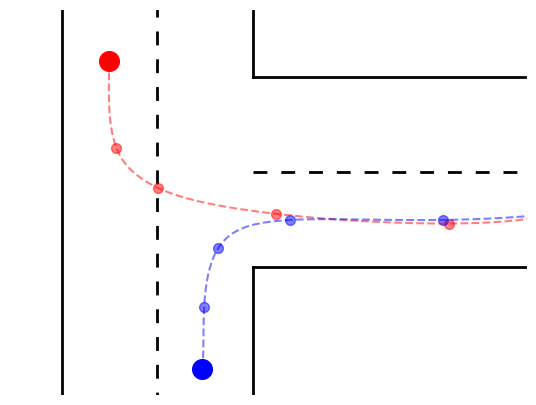

In [15]:
from visualizer import TIntersectionVisualizer
vis = TIntersectionVisualizer()
state = ["ego_1", "car_1"]
vis.plot(state)

Do the following task:
1. Choose an initial state
2. From the computed $V^*(x), \pi^*(x)$, iterate from the chosen initial state gradually until you reach the terminal state, i.e. `["ego_5", "car_5"]`.
3. While iterating, keep track of your state-action pair $(s, a)$. Print out all the state-action pairs that your computed $V^*(x), \pi^*(x)$ navigate you to.

*Hint 1*: For each state and action pair $(s, a)$, the matrix P will show you the probability of $s'$ by calling `P[:, state_index, action_index]`

*Hint 2*: Assuming that you have a list of states `S` and the probability distribution `p` of the states in `S`, you can use `numpy.random.choice(S, p=p)` to sample the next state, given `S` and `p`.

In [37]:
## YOUR CODE HERE
def get_solution(initial_state):
    done = False
    state = initial_state 
    state_list = [state]
    print("State: {}\tAction: {}".format(state, None))

    while not done:
        ## YOUR CODE HERE
        # 1. Get index of current state
        curr_state_index = tinter.get_index(state)
        # 2. Get next action based on pi_star and state index
        next_action = pi_star[curr_state_index] # next action according to magic policy
        
        # 3. Get indices of all the possible next states and their transition probabilities
        state_transition_probs = tinter.P[:, curr_state_index, int(next_action)] # new state, old state, action
        next_state_indices = np.where(state_transition_probs > 0.0)[0]

        # 4. Sample next state index, given the transition probabilities
        next_state_index = np.random.choice(a=next_state_indices, size=1, p=state_transition_probs[next_state_indices])
        
        # 5. Append new state (readable form, e.g. ["ego_1", "car_2"]) to state_list
        state = tinter.get_real_state_value(next_state_index)
        state_list.append(state)

        if state[0] == "ego_5" or state[1] == "car_5":
            done = True

    return state_list

initial_state = ["ego_1", "car_1"] # choose an initial condition
state_list = get_solution(initial_state)
print(state_list)


State: ['ego_1', 'car_1']	Action: None
[['ego_1', 'car_1'], ['ego_2', 'car_1'], ['ego_4', 'car_2'], ['ego_5', 'car_2']]


/var/folders/rt/495w1d4n0qgc9147468sky5h0000gn/T/ipykernel_38175/1735534440.py:24: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


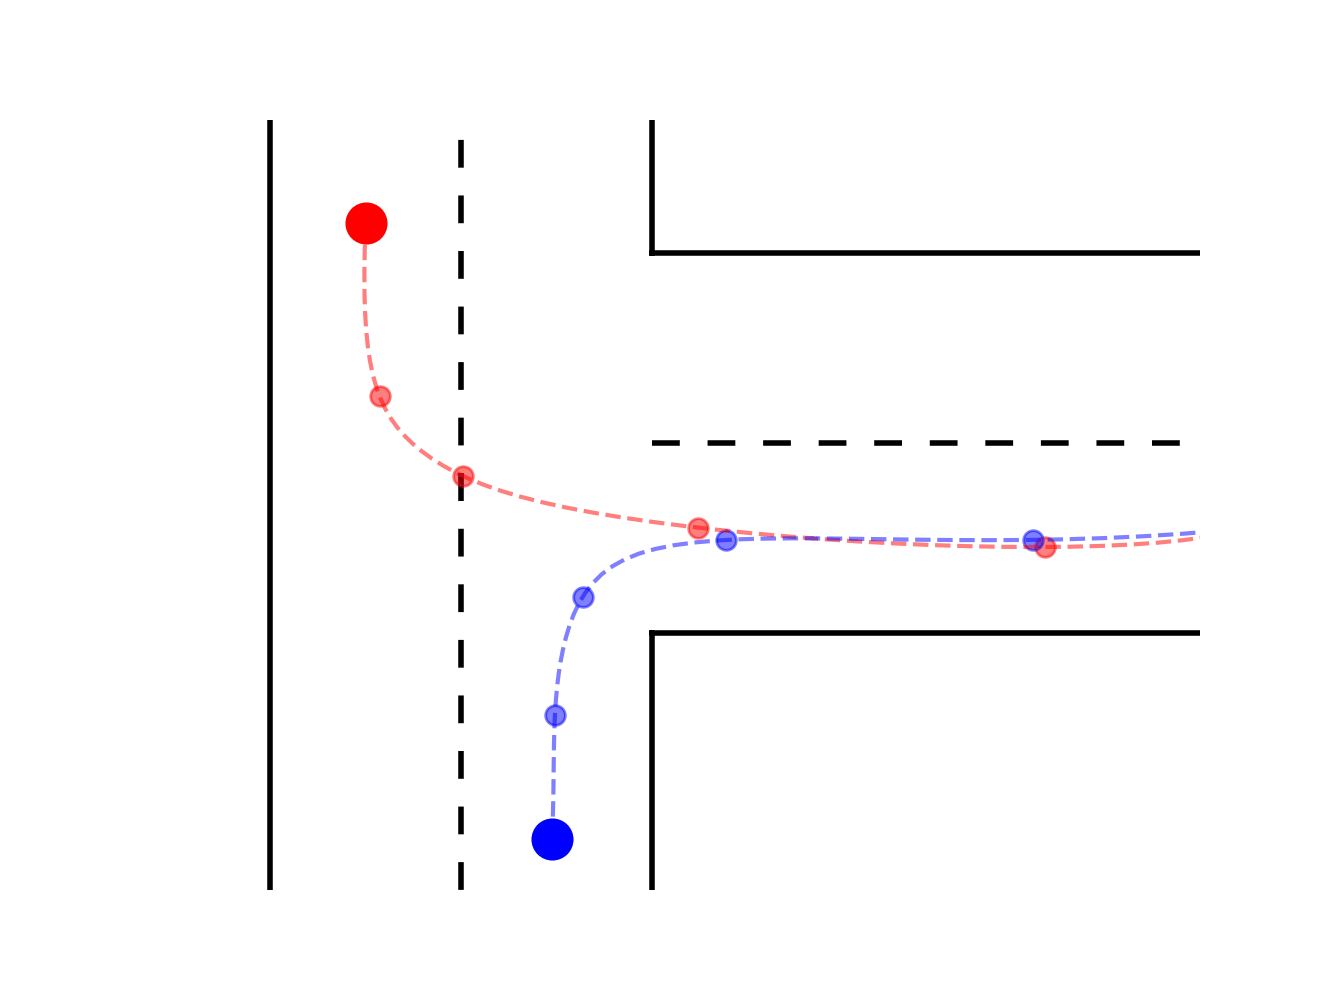

<Figure size 666.667x500 with 0 Axes>

In [43]:
import imageio
from IPython.display import Image

folder = "figures"
sub_folder = "mdp"

fig_prog_folder = os.path.join(folder, sub_folder)
if os.path.exists(fig_prog_folder):
    print("WARNING: Path {} exists, GIF result might be affected with old data".format(fig_prog_folder))
os.makedirs(fig_prog_folder, exist_ok=True)

for i, state in enumerate(state_list):
    vis.plot(state)
    plt.savefig(os.path.join(fig_prog_folder, "{}.png".format(i)), dpi=200)
    plt.clf()

gif_path = os.path.join(fig_prog_folder, 'result.gif')
length = len([i for i in os.listdir(os.path.join(fig_prog_folder)) if ".png" in i])

with imageio.get_writer(gif_path, mode='I') as writer:
    for i in range(length):
        print(i, end='\r')
        filename = os.path.join(fig_prog_folder, str(i)+".png")
        image = imageio.imread(filename)
        writer.append_data(image)
Image(open(gif_path,'rb').read(), width=400)

Let's play around with this a bit. Let's change the default reward function of our MDP.

The class `TIntersection()` takes in a dictionary with reward information of the following structure:

```python
TIntersection(reward = {
    "forward": forward_r,
    "stop": stop_r,
    "collision": collision_r,
    "goal": goal_r
})
```

Let's change the reward function and see how it affects the $\pi^*$

In [39]:
tinter = TIntersection(reward={
    "forward": 0.0,
    "stop": -1.0,
    "collision": -100,
    "goal": 20
})

In [40]:
V_star, pi_star = value_iteration(mdp=tinter, threshold=1e-5)
print("V*: {}".format(V_star))
print("pi*: {}".format(pi_star))

V*: [ 87.57160044  93.53267843 101.83906706 116.23906706 136.23906706
 100.72497909 100.72497909 100.72497909  88.16326531 108.16326531
 125.76549852 125.76549852 125.76549852  51.42857143  71.42857143
 154.34772915 154.34772915 154.34772915   0.           0.
 199.99990306 199.99990306 199.99990306   0.           0.        ]
pi*: [0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0.
 0.]


In [42]:
initial_state = ["ego_1", "car_3"] # choose an initial state
get_solution(initial_state)

State: ['ego_1', 'car_3']	Action: None


[['ego_1', 'car_3'],
 ['ego_1', 'car_4'],
 ['ego_1', 'car_4'],
 ['ego_1', 'car_4'],
 ['ego_1', 'car_4'],
 ['ego_1', 'car_4'],
 ['ego_1', 'car_4'],
 ['ego_1', 'car_5']]

With this new reward function, it is not good almost everywhere to choose the action 0, i.e. forward.

## 2. QMDP
### Task 2.1: Defining new MDP
Assume that in this new problem, we do not know exactly where the other car is. Let's introduce a new action called *look* into our problem formulation. Everytime we choose the action *look*, no car moves, we get a $-1$ reward, and receives the observation $z \in \{1 \dots 5\}$ corresponding to the position of the other car.

The first thing we will do to approximate this POMDP with QMDP is to solve for the underlying MDP formulation (assuming that all states are fully observable).

Tasks:
1. Edit the class `TIntersection()` to include the new information mentioned
2. Use value iteration/policy iteration and solve for $\hat{V}^{\text{MDP}}$

**NOTE**: You can copy the value of all the missing probability values from the previous questions (denotes `MISSING_VALUE`)

In [ ]:
class TIntersectionQMDP(MDP):
    def __init__(self, reward={"forward": -1, "stop": -5, "collision": -10, "goal": 5.0, "look": -1}):
        self.states = [
            ["ego_{}".format(x) for x in list(range(1, 6))],
            ["car_{}".format(x) for x in list(range(1, 6))]
        ]
        
        # 1. Add another action "look" to self.actions
        self.actions = ["forward", "stop"]

        self.gam = 0.9
        super().__init__(
            states=self.states, actions=self.actions, method="add")
        self.reward = reward
        self.populate_data()
        
    def populate_data(self):
        for i in range(1, 6):
            for j in range(1, 6):
                # add route for forward action
                # (i, j) --> (i+1, j)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+1, 5)), "car_{}".format(j)], MISSING_VALUE)
                # (i, j) --> (i+1, j+1)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+1, 5)), "car_{}".format(min(j+1, 5))], MISSING_VALUE)
                # (i, j) --> (i+1, j+2)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+1, 5)), "car_{}".format(min(j+2, 5))], MISSING_VALUE)
                # (i, j) --> (i+2, j)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+2, 5)), "car_{}".format(j)], MISSING_VALUE)
                # (i, j) --> (i+2, j+1)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+2, 5)), "car_{}".format(min(j+1, 5))], MISSING_VALUE)
                # (i, j) --> (i+2, j+2)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "forward", ["ego_{}".format(min(i+2, 5)), "car_{}".format(min(j+2, 5))], MISSING_VALUE)

                # add route for stop action
                # (i, j) --> (i+2, j)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "stop", ["ego_{}".format(i), "car_{}".format(min(j+2, 5))], MISSING_VALUE)
                # (i, j) --> (i+1, j)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "stop", ["ego_{}".format(i), "car_{}".format(min(j+1, 5))], MISSING_VALUE)
                # (i, j) --> (i, j)
                self.add_route(["ego_{}".format(i), "car_{}".format(j)], "stop", ["ego_{}".format(i), "car_{}".format(j)], MISSING_VALUE)

                self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "forward", self.reward["forward"])
                self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "stop", self.reward["stop"])

                # add route and reward for look action
                ## YOUR CODE HERE
                # self.add_route(...., "look", ...., p=...)
                # ...
                # self.add_reward(..., "look", self.reward["look"])
                ######
                        
                # check for collision
                if (i in [4, 5]) and (j in [4, 5]):
                    self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "forward", self.reward["collision"])
                    self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "stop", self.reward["collision"])
                    self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "look", self.reward["collision"])
                elif (i == 5) or (j == 5):
                    # reaching goal
                    self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "forward", self.reward["goal"])
                    self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "stop", self.reward["goal"])
                    self.add_reward(["ego_{}".format(i), "car_{}".format(j)], "look", self.reward["goal"])

In [ ]:
tinter_qmdp = TIntersectionQMDP()

### Task 2.2: QMDP
Write the QMDP function to get the **next action**, taking in consideration the belief space.

In [ ]:
# calculate the V_star using previously built value iteration
V_star, pi_star = value_iteration(mdp=tinter_qmdp, threshold=1e-4)

In [ ]:
def QMDP(V_star, belief, mdp:MDP=None):
    if mdp is None:
        raise ValueError("MDP cannot be None")
    
    numa, nums, R, P = mdp.get_mdp()

    # compute MDP-value for state-action pairs (Q)
    ####
    ## YOUR CODE HERE
    raise NotImplementedError("Your QMDP function is empty")

    ####
    return None

As we know exactly where we are all the time, and we only do not know where the other car is. Let us keep track of the probability distribution of where the other car is using an array of `b = [p_1, p_2, p_3, p_4, p_5]`, with `p_i` indicates the probability that the other car is at the $i^\text{th}$ position, $i \in \{1 \dots 5\}$.

We then provide you with the function `propagate_belief()` to incorporate our current position to give you the full array of belief space $\in \mathbb{R}^{25}$

**Example**: Let us have our current belief `b = [0.2, 0.2, 0.2, 0.2, 0.2]` and that we are at `ego_1`, running `propagate_belief(b, "ego_1")` gives us:

```python
propagate_belief(b, "ego_1")
>>> [0.2 0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.2 0.  0.
 0.  0.  0.2 0.  0.  0.  0. ]
```

This is because the state array is in the form `[(ego_1, car_1), (ego_1, car_2), ..., (ego_2, car_1), (ego_2, car_2), ..., (ego_5, car_5)]`.

In [ ]:
# assume that the initial belief space is {0.2, 0.2, 0.2, 0.2, 0.2} for the 5 positions that the other car can be in
# if *look* is chosen, we will receive the observation of where the other car is, with probability distribution 
# p(pos-1) = 0.1, p(pos)=0.8, p(pos+1)=0.1 with pos is the true position
b = [0.2, 0.2, 0.2, 0.2, 0.2]

# write a function to propagate the belief space to include our position as well
def propagate_belief(b_car, ego_state):
    idx = int(ego_state.replace("ego_", "")) - 1
    b_full = np.zeros(25)
    for i, p in enumerate(b_car):
        b_full[i*5 + idx] = p
    return b_full

print(propagate_belief(b, "ego_1"))

In [ ]:
## TEST YOUR CODE
# we know exactly where we are, and we are confident that the other car is at position 1
belief = propagate_belief([1.0, 0.0, 0.0, 0.0, 0.0], "ego_1")
next_action = QMDP(V_star, belief, mdp=tinter_qmdp)
print("Best next action: {}".format(next_action))

# we know exactly where we are, and we are confident that the other car is at position 3
belief = propagate_belief([0.0, 0.0, 1.0, 0.0, 0.0], "ego_3")
next_action = QMDP(V_star, belief, mdp=tinter_qmdp)
print("Best next action: {}".format(next_action))

# we know exactly where we are, and we are not that confident where the other is, with high prop that
# it's around position 2 or 3
belief = propagate_belief([0.0, 0.4, 0.5, 0.1, 0.0], "ego_3")
next_action = QMDP(V_star, belief, mdp=tinter_qmdp)
print("Best next action: {}".format(next_action))

### Task 2.3: Observation and belief space

In [ ]:
# assume that the initial belief space is {0.2, 0.2, 0.2, 0.2, 0.2} for the 5 positions that the other car can be in
# if *look* is chosen, we will receive the observation of where the other car is, with probability distribution 
# p(pos-1) = 0.1, p(pos)=0.8, p(pos+1)=0.1 with pos is the true position
b = [0.2, 0.2, 0.2, 0.2, 0.2]

# write a function to propagate the belief space to include our position as well
def propagate_belief(b_car, ego_state):
    idx = int(ego_state.replace("ego_", "")) - 1
    b_full = np.zeros(25)
    for i, p in enumerate(b_car):
        b_full[i*5 + idx] = p
    return b_full

We will use Bayesian inference to update our belief using the observation, and we will model our belief space as a multinomial distribution, so that we can easily do Bayesian inference with conjugate prior. In this case, it will be Dirichlet distribution.

In [ ]:
class DirichletMultinominal:
    def __init__(self, alpha=[1, 1, 1, 1, 1]):
        self.alpha = alpha
        self.observations = []
    
    def reset(self):
        self.observations = []
    
    def get_posterior_predictive(self, observations=[]):
        ### YOUR CODE HERE
        # 1. Append the new observations to the internal observation list
        # 2. Calculate the predictive posterior distribution and return
        raise NotImplementedError
        ###
        return None


In [ ]:
### TEST YOUR CODE
dist = DirichletMultinominal()
assert dist.get_posterior_predictive() == [0.2, 0.2, 0.2, 0.2, 0.2]
assert dist.get_posterior_predictive(observations=[0, 0, 0, 0, 0]) == [0.6, 0.1, 0.1, 0.1, 0.1]
dist.reset()
assert dist.get_posterior_predictive(observations=[1, 1, 1, 1, 1]) == [0.1, 0.6, 0.1, 0.1, 0.1]
print("Everything is correct!")

Run the last block to simulate our QMDP. Does the result make sense?

Run it a few times, as well as changing the initial state so that you can see different results.

In [ ]:
done = False
state = ["ego_1", "car_1"]
state_list = [state]
b = dist.get_posterior_predictive()
print("State: {}\tAction: {}\tBelief: {}".format(state, None, b))

while not done:
    belief = propagate_belief(b, state[0])
    next_action = QMDP(V_star=V_star, belief=belief, mdp=tinter_qmdp)
    
    if int(next_action) == 2:
        true_state_idx = int(state[1].replace("car_", "")) - 1
        obs = np.random.choice([min(true_state_idx-1, 0), true_state_idx, min(true_state_idx+1, 4)], p=[0.1, 0.8, 0.1])
        b = dist.get_posterior_predictive([obs])
    elif int(next_action) == 0:
        dist.reset()
        b = dist.get_posterior_predictive()

    state_index = tinter_qmdp.get_index(state)

    next_state_indices = np.where(tinter_qmdp.P[:, state_index, int(next_action)] > 0.0)[0]
    next_state_p = tinter_qmdp.P[:, state_index, int(next_action)][next_state_indices]
    next_state_index = np.random.choice(next_state_indices, p=next_state_p)
    
    state = tinter_qmdp.get_real_state_value(next_state_index)
    state_list.append(state)

    if state[0] == "ego_5" or state[1] == "car_5":
        done = True
    
    print("State: {}\tAction: {}\tBelief: {}".format(state, next_action, b))